In [1]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols

from rdkit.Avalon import pyAvalonTools as fpAvalon
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy.optimize import linprog
from sklearn import manifold

In [2]:
data = pd.read_csv("Data.csv").drop(['Unnamed: 0'], axis = 1)
# Add column for activity
data["active"] = np.zeros(len(data))
# Mark every molecule as active with an pIC50 of >= 7, 0 otherwise
data.loc[data[data['pChEMBL Value'] >= 7].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(data.active.sum()))
print("Number of inactive compounds:", len(data) - int(data.active.sum()))

from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(data, stratify = data.active, random_state = 42)
df_external = df_test.copy()

from rdkit import Chem, DataStructs 
from rdkit.Chem import Descriptors, Draw, PandasTools, AllChem
PandasTools.AddMoleculeColumnToFrame(df_train, smilesCol = 'Canomial_smiles')
PandasTools.AddMoleculeColumnToFrame(df_test, smilesCol = 'Canomial_smiles')
#PandasTools.AddMoleculeColumnToFrame(df_external, smilesCol = 'Canomial_smiles')

Number of active compounds: 596
Number of inactive compounds: 1849


# 1. Fingerprint based PCA

In [3]:
import sys
sys.path.append('MolAD')
from preprocessing import prepare_dataset
from pca_convexhull import PCA_convexhull
from pca_confelip import PCA_conf_elip

reading NP model ...
model in


In [4]:
process = prepare_dataset(data_train=df_train, data_test=df_test, smile_col ='Canomial_smiles',
                    activity_col='pChEMBL Value',feature_col = None,
                    mol_col = 'ROMol', ID = 'Molecule ChEMBL ID', fp_type='ECFPs')
process.fit()

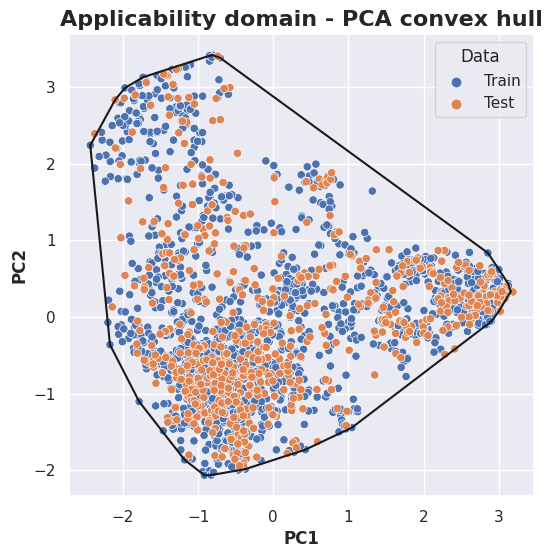

In [5]:
convex = PCA_convexhull(data =process.df_pca, Type = 'Data', ID = 'ID', figsize = (6,6), savefig=True)
convex.convexhull_fit()

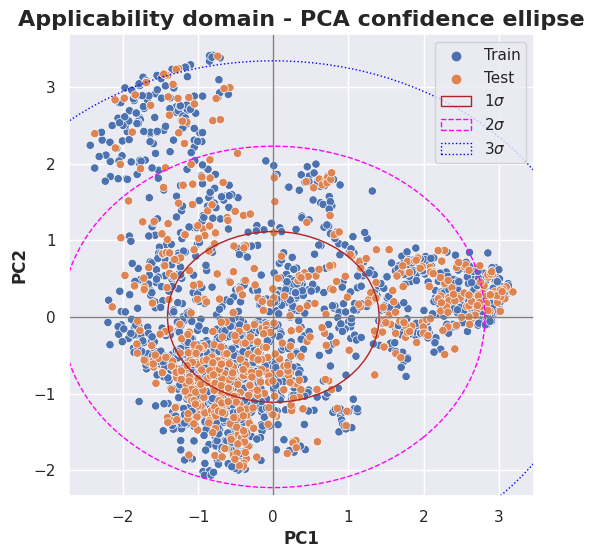

In [18]:
elip = PCA_conf_elip(data =process.df_pca, Type = 'Data', ID = 'ID', figsize =(6,6), savefig= True)
elip.fit()

# 2. Similarity convexhull

In [7]:
from similarity_matrix import similarity_matrix 
from similarity_convexhull import similarity_convexhull

In [9]:
simi = similarity_matrix(data_train=df_train, data_test=df_test, 
                         ID = 'Molecule ChEMBL ID', mol_col='ROMol',
                        function =None)
simi.fit()

In [12]:
simi.matrix.to_csv('matrix.csv', index = None)

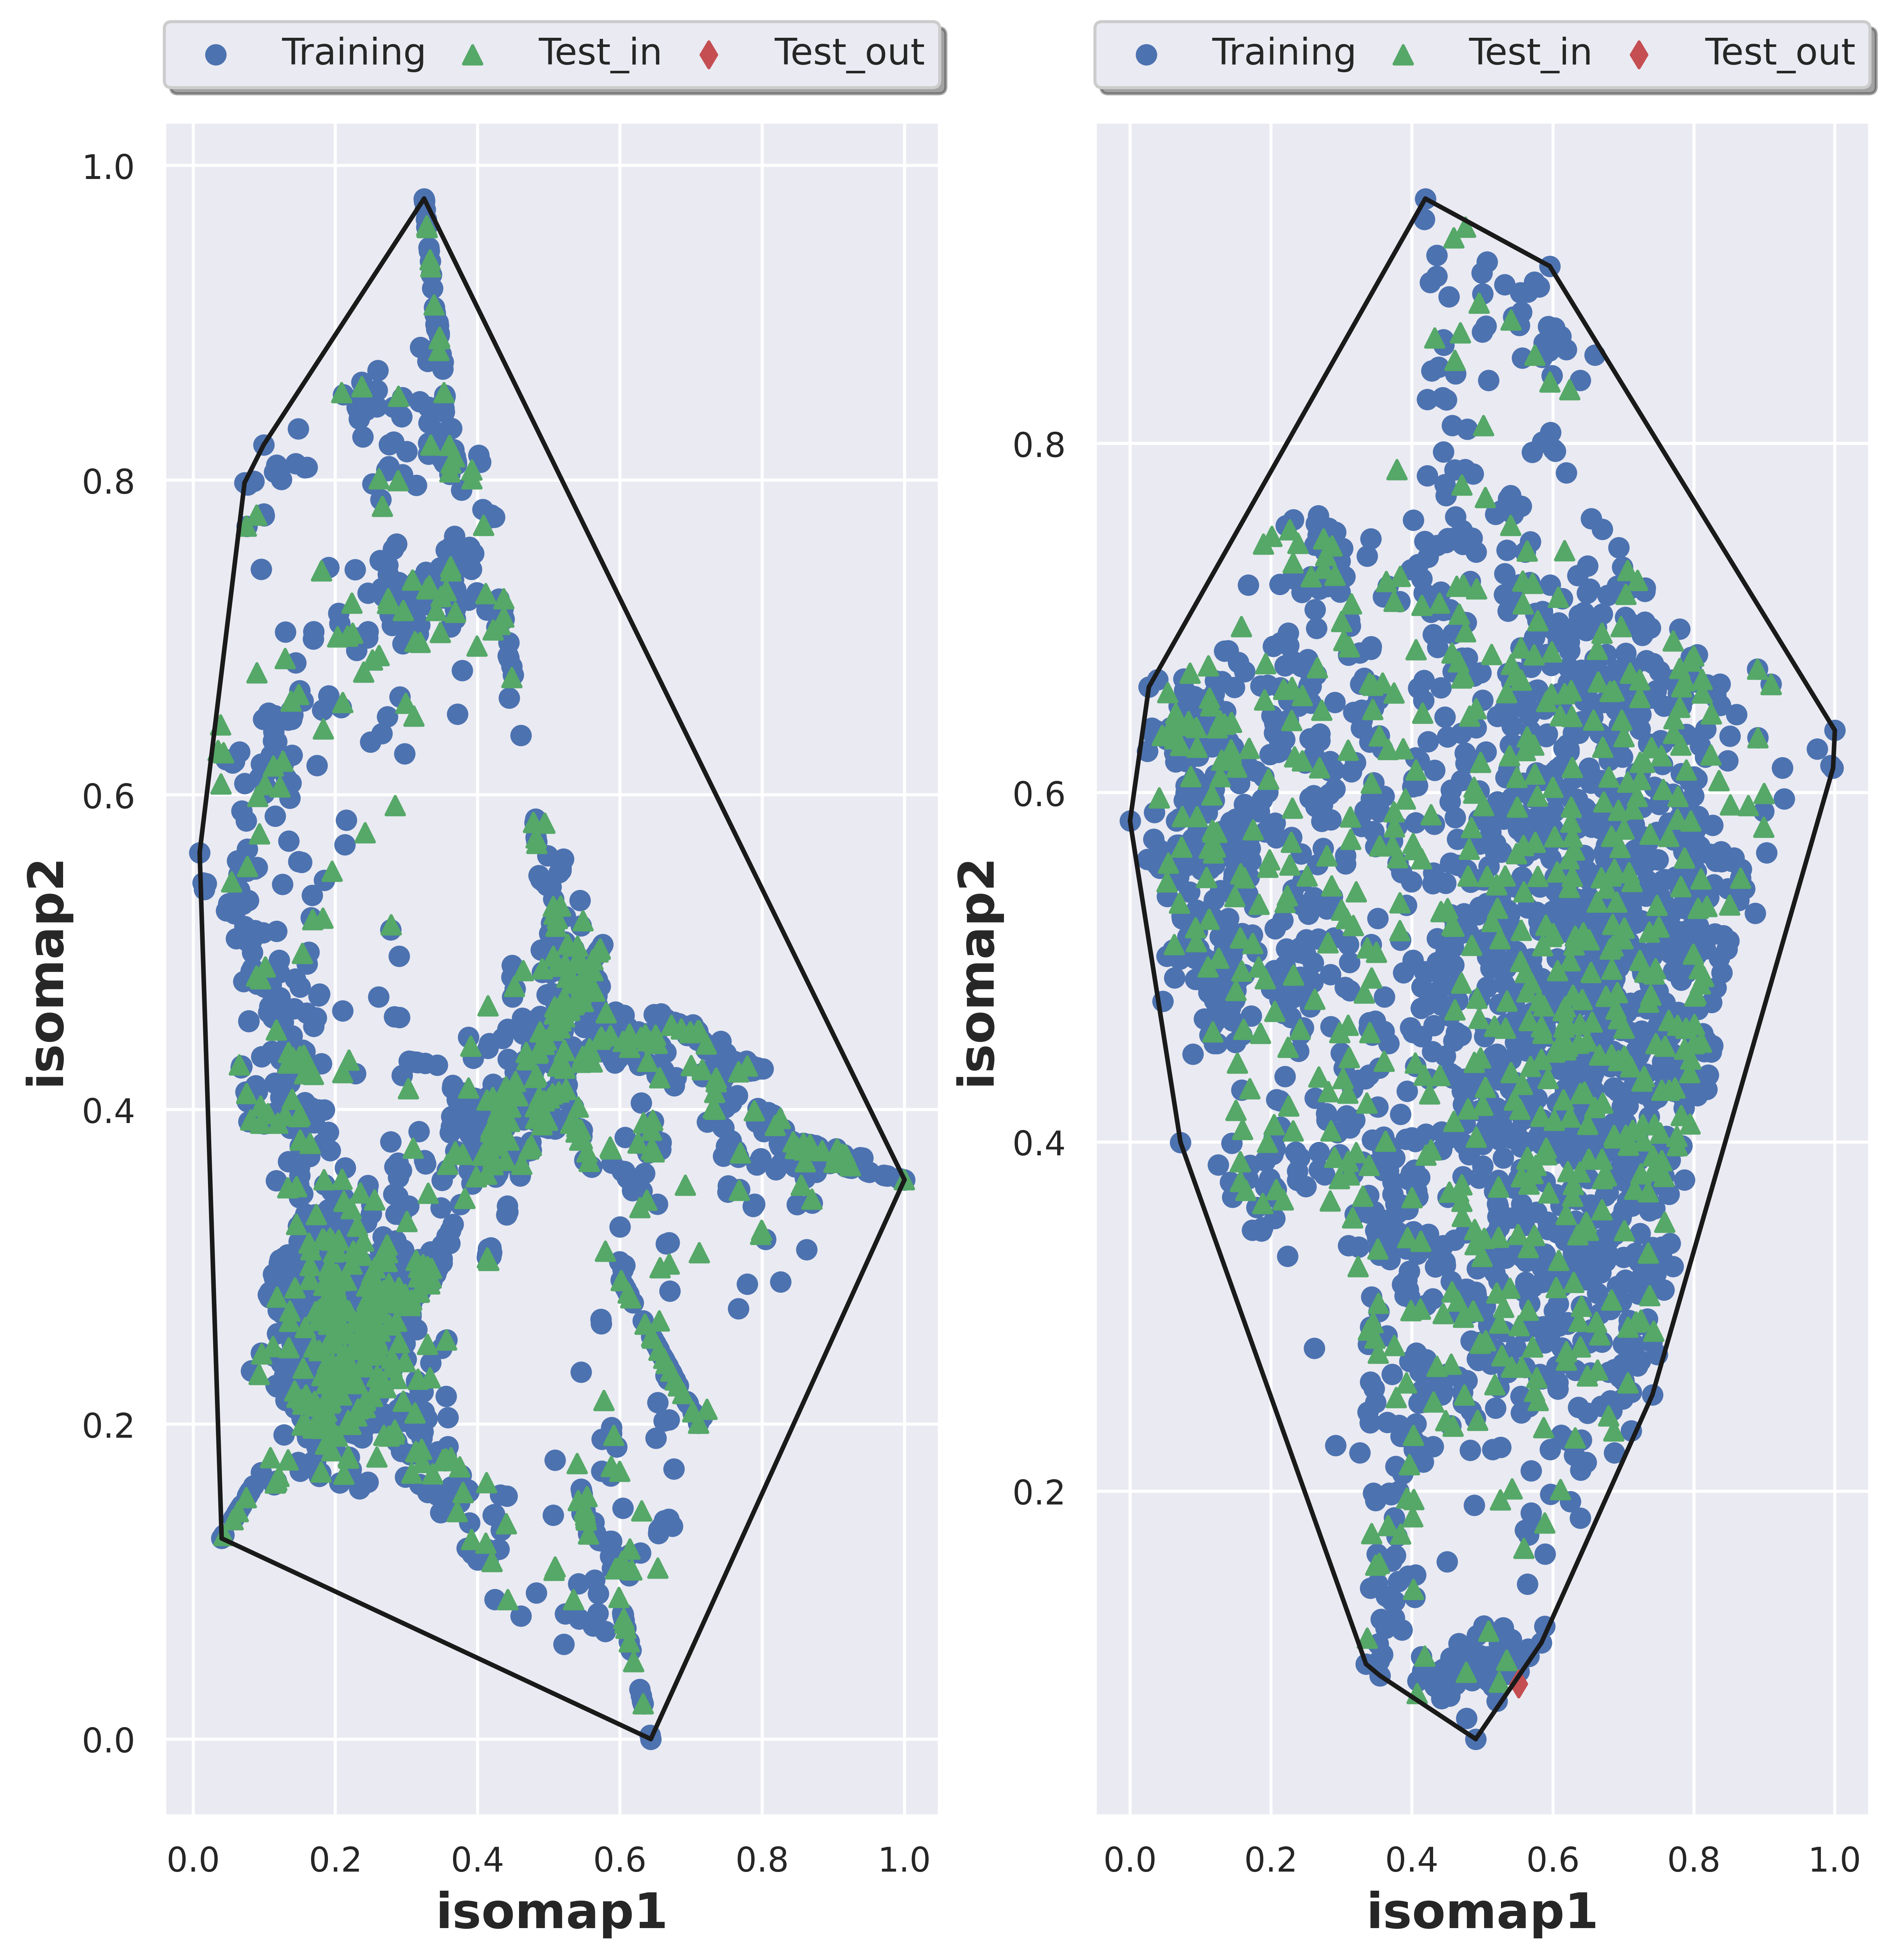

In [17]:
cv =  similarity_convexhull(data =simi.matrix, list_training_fp= simi.list_training_fp, 
                            list_test_fp =simi.list_test_fp, figsize=(8,8), save_fig=True)
cv.fit()